# Notes to Ch. 15: Incrementality - Causality

In [1685]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import cm
import matplotlib.colors as colors
import cycler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from scipy.stats import gaussian_kde

# set plotting parameters from the beginning
font = {'family' : 'monospace',
        'weight' : 'normal',
        'size'   : 14}
axes = {'titlesize' : 22,
        'labelsize' : 20,
       'prop_cycle' : cycler.cycler(color='k')}
lines = {'color' : 'k'}
figure = {'figsize' : (10,4),
         'autolayout' : True,}
matplotlib.rc('font', **font)
matplotlib.rc('axes', **axes)
matplotlib.rc('figure', **figure)
matplotlib.rc('lines', **lines)


## Colliders and confounders:

* Let's start by simulating the effect of a `confounder`: $C \rightarrow X, C \rightarrow Y$
* And a `collider`: $X \rightarrow C, Y \rightarrow C$

In [1686]:
def simulate_confounder(nobs, seed):
    "Simulate confounder"
    np.random.seed(seed)
    c = np.random.randn(nobs)
    noice_x = np.sqrt(1)*np.random.randn(nobs)
    x = 10 + 0.5*c + noice_x
    noice_y = np.sqrt(2)*np.random.randn(nobs)
    y = -2 + 3*c + noice_y

    return y,x,c

        
def run_mc(nobs, seed_mc, num_montecarlo, fun_to_simulate, **kwargs):
    "Monte Carlo simulation function"
    np.random.seed(seed_mc)
    seed_arr = np.random.randint(low=1, high=2*num_montecarlo, size = num_montecarlo)
    df_results = pd.DataFrame(index=range(num_montecarlo), 
                              columns = ['beta_biased', 'beta_unbiased'], dtype='float')
    for i in range(num_montecarlo):
        if kwargs:
            rho = kwargs['rho']
            my_func = fun_to_simulate(nobs, rho = rho, seed=seed_arr[i])
        else:
            my_func = fun_to_simulate(nobs, seed=seed_arr[i])
        y,x,c = my_func
        x = x.reshape((nobs,1))
        c = c.reshape((nobs,1))
        # regression of y on X
        regi = LinearRegression(fit_intercept=True).fit(x,y)
        coef_x = regi.coef_[0]
        # regression of y on X,C
        xmat = np.concatenate((x,c), axis=1)
        regc = LinearRegression(fit_intercept=True).fit(xmat,y)
        coef_xc = regc.coef_[0]
        df_results.beta_biased.loc[i] = coef_x
        df_results.beta_unbiased.loc[i] = coef_xc
        
    # compute mean and ci
    pmin, pmax = 0.025, 0.975
    mean = df_results.mean()
    ci = df_results.quantile([pmin, pmax])
    ci.rename(index={pmin: f'q_{100*pmin}', pmax: f'q_{100*pmax}'}, inplace=True)
    ci.loc['mean'] = mean.values
    
    return ci
    

In [1687]:
def plot_mc_results(df, ax):
    "Plot results crom MC"
    mean_mc = df.loc['mean']
    yerr = df.loc[['q_2.5', 'q_97.5']]
    mean_mc.plot(kind='bar', ax=ax, edgecolor='k', facecolor='0.5')
    ax.set_xticks([0,1])
    for c, col in enumerate(yerr.columns):
        ax.plot([c,c], yerr[col])
    xmin, xmax = ax.get_xlim()
    ax.plot([xmin, xmax], [0,0], lw=0.5)
    return ax

Text(0.5, 1.0, 'Confounder Bias: Mean and 95% CI (estimate for X)')

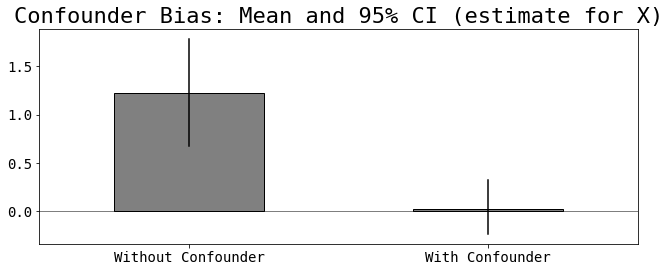

In [1688]:
nobs = 100
seed_mc = 26318
num_montecarlo = 300
ci_conf = run_mc(nobs, seed_mc, num_montecarlo, fun_to_simulate = simulate_confounder)
# plot
fig, ax = plt.subplots()
ax = plot_mc_results(df = ci_conf, ax = ax)
ax.set_xticks([0,1])
ax.set_xticklabels(['Without Confounder', 'With Confounder'], rotation=0)
ax.set_title('Confounder Bias: Mean and 95% CI (estimate for X)')

In [1689]:
def simulate_collider(nobs, seed):
    "Simulate confounder"
    np.random.seed(seed)
    noice_x = np.sqrt(1)*np.random.randn(nobs)
    x = 10 + noice_x
    noice_y = np.sqrt(2)*np.random.randn(nobs)
    y = -2 + noice_y
    # X -> C, Y -> C
    noice_c = np.sqrt(0.1)*np.random.randn(nobs)
    c = 5 - 2*x + 10*y + noice_c
    
    return y,x,c

Text(0.5, 1.0, 'Collider Bias: Mean and 95% CI')

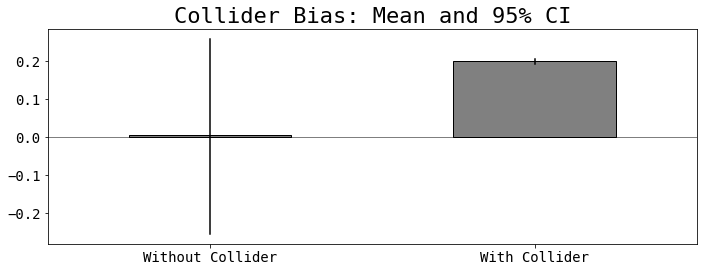

In [1690]:
nobs = 100
seed_mc = 26318
num_montecarlo = 300
ci_col = run_mc(nobs, seed_mc, num_montecarlo, fun_to_simulate = simulate_collider)
# plot
fig, ax = plt.subplots()
ax = plot_mc_results(df = ci_col, ax = ax)
ax.set_xticks([0,1])
ax.set_xticklabels(['Without Collider', 'With Collider'], rotation=0)
ax.set_title('Collider Bias: Mean and 95% CI')

In [1691]:
def simulate_collider_causal(nobs, seed):
    "Simulate confounder: but X-->Y so there's a causal effect"
    np.random.seed(seed)
    noice_x = np.sqrt(1)*np.random.randn(nobs)
    x = 10 + noice_x
    noice_y = np.sqrt(2)*np.random.randn(nobs)
    y = -2 + 2*x + noice_y
    # X -> C, Y -> C
    noice_c = np.sqrt(0.1)*np.random.randn(nobs)
    c = 5 - 2*x + 10*y + noice_c
    
    return y,x,c

Text(0.5, 1.0, 'Collider Bias (Causal): Mean and 95% CI')

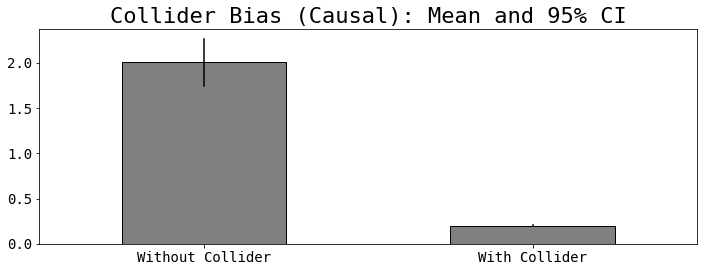

In [1692]:
nobs = 100
seed_mc = 26318
num_montecarlo = 300
ci_col_c = run_mc(nobs, seed_mc, num_montecarlo, fun_to_simulate = simulate_collider_causal)
# plot
fig, ax = plt.subplots()
ax = plot_mc_results(df = ci_col_c, ax = ax)
ax.set_xticks([0,1])
ax.set_xticklabels(['Without Collider', 'With Collider'], rotation=0)
ax.set_title('Collider Bias (Causal): Mean and 95% CI')

Text(0.5, 1.0, 'Collider Bias (causal)')

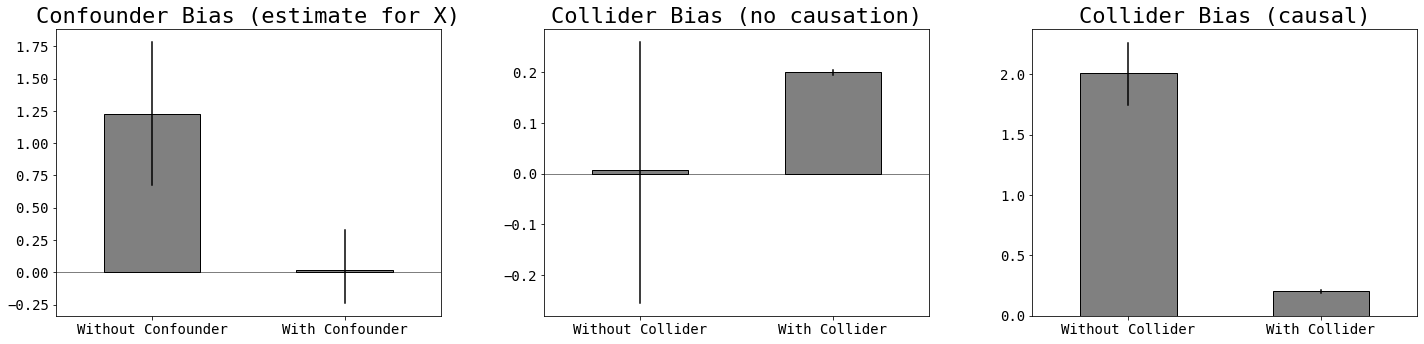

In [1693]:
# plot the three
fig, ax = plt.subplots(1,3, figsize = (20,5))
# confounder
ax0 = ax[0]
ax0 = plot_mc_results(df = ci_conf, ax = ax0)
ax0.set_xticks([0,1])
ax0.set_xticklabels(['Without Confounder', 'With Confounder'], rotation=0)
ax0.set_title('Confounder Bias (estimate for X)')
# collider without causation
ax1 = ax[1]
ax1 = plot_mc_results(df = ci_col, ax = ax1)
ax1.set_xticks([0,1])
ax1.set_xticklabels(['Without Collider', 'With Collider'], rotation=0)
ax1.set_title('Collider Bias (no causation)')
# collider with causation
ax2 = ax[2]
ax2 = plot_mc_results(df = ci_col_c, ax = ax2)
ax2.set_xticks([0,1])
ax2.set_xticklabels(['Without Collider', 'With Collider'], rotation=0)
ax2.set_title('Collider Bias (causal)')

Text(0.5, 1.0, 'Collider Bias (estimate for X)')

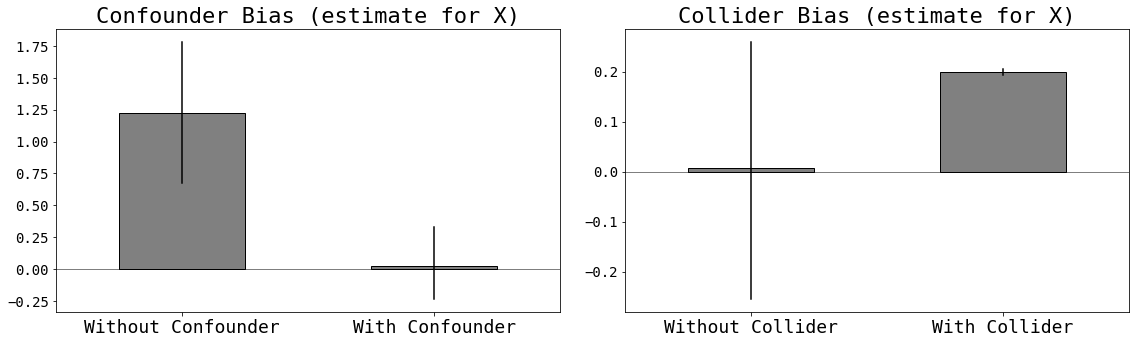

In [1694]:
# plot only two
fig, ax = plt.subplots(1,2, figsize = (16,5))
# confounder
ax0 = ax[0]
ax0 = plot_mc_results(df = ci_conf, ax = ax0)
ax0.set_xticks([0,1])
ax0.set_xticklabels(['Without Confounder', 'With Confounder'], rotation=0, fontsize=18)
ax0.set_title('Confounder Bias (estimate for X)')
# collider without causation
ax1 = ax[1]
ax1 = plot_mc_results(df = ci_col, ax = ax1)
ax1.set_xticks([0,1])
ax1.set_xticklabels(['Without Collider', 'With Collider'], rotation=0, fontsize=18)
ax1.set_title('Collider Bias (estimate for X)')

### What happens if you don't observe a confounder, but only a proxy of it?

* Let's simulate this

In [1695]:
def simulate_xmatrix_rho(nobs, nfeats, rho, seed):
    """
    Simulate a feature matrix with normally distributed features
    """
    np.random.seed(seed)
    # first step: construct the vcv with unit variances and rho elsewhere
    pre_vcv = np.array([[rho]*nfeats]*nfeats)
    iden_mtx = np.eye(nfeats)
    vcv = iden_mtx + (1-iden_mtx)*pre_vcv
    # second step: draw from 
    mu = [0]*nfeats
    Xdf = pd.DataFrame(np.random.multivariate_normal(mean = mu, cov = vcv, size=nobs), 
                      columns = [f'x{i+1}' for i in range(nfeats)])
    return Xdf

def simulate_conf_proxy(nobs, rho, seed):
    "Simulate confounder bias with a correlated proxy"
    np.random.seed(seed)
    # generate confounder and proxy
    cdf = simulate_xmatrix_rho(nobs, nfeats=2, rho=rho, seed=seed)
    c = cdf['x1'].values
    proxy = cdf['x2'].values
    # c --> x
    noice_x = np.sqrt(1)*np.random.randn(nobs)
    x = 10 + 0.5*c + noice_x
    # now y = f(x,c)
    noice_y = np.sqrt(2)*np.random.randn(nobs)
    y = -2 + 3*c - 2*x + noice_y


    return y,x,proxy
    

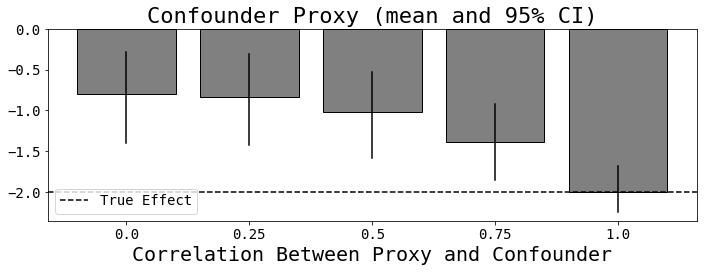

In [1696]:
nobs = 100
seed_mc = 83511
num_montecarlo = 300
rho_grid = np.linspace(0,1,5)
fig, ax = plt.subplots()
for r, rho_r in enumerate(rho_grid):
    mc_r = run_mc(nobs, seed_mc, num_montecarlo, fun_to_simulate = simulate_conf_proxy, rho = rho_r)
    mean_r = mc_r.beta_unbiased.loc['mean']
    low_r, high_r = mc_r.beta_unbiased.loc[['q_2.5', 'q_97.5']].values
    ax.bar(r, mean_r, color = '0.5', edgecolor='k')
    ax.plot([r,r], [low_r, high_r], color='k')

xmin, xmax = ax.get_xlim()
true = ax.plot([xmin, xmax], [-2,-2], ls='--')
ax.legend(true, ['True Effect'], loc=3)
xlim = ax.set_xlim([xmin, xmax])
xtks = ax.set_xticks(list(range(len(rho_grid))))
xtks_l = ax.set_xticklabels(rho_grid)
ax.set_xlabel('Correlation Between Proxy and Confounder')
ttl = ax.set_title('Confounder Proxy (mean and 95% CI)')

## Selection bias:

There is `selection bias` whenever the assignment probability depends on the potential outcomes (Imbens & Rubin's _unconfounded assignment_ assumption).  Angrist & Pischke call this _Conditional Independence Assumption_ (${Y_{0i}, Y_{1i} \perp D_i | X_i}$), $X_i$ are the _observed_ confounders for unit _i_)

Simulate a typical DAG with selection-bias:

* `Z`: confounder
* `D`: binary treatment (function of `Z`)
* `Y`: outcome

DAG usually has confounding, but we will also simulate the case of now confounding, so the second arrow disappears.
$$
\begin{eqnarray}
Z &\rightarrow& D \rightarrow Y \\
Z &\rightarrow& Y
\end{eqnarray}
$$

The idea is that 

* Z affects selection into the treatment
* It also affects Y (so there's confounding)

Let's take a linear model as example:

$$
\begin{eqnarray}
Y_i &=& \alpha_0 + \alpha_1 D_i + \alpha_2 z_i + \epsilon_i \\
\text{Prob}(D_i = 1|z_i) &=& \text{Prob}(\beta_0 + \beta_1 z_i + \eta_i >=0)
\end{eqnarray}
$$

The potential outcomes would be:

$$
\begin{eqnarray}
Y_{0i} &=& \alpha_0 + \alpha_2 z_i + \epsilon_i \\
Y_{1i} &=& \alpha_0 + \alpha_1 + \alpha_2 z_i + \epsilon_i \\
\end{eqnarray}
$$

**Note**: this usage of `selection bias` is common in statistics and econometrics.  Judea Pearl and collaborators have a different [definition](https://ftp.cs.ucla.edu/pub/stat_ser/r425.pdf).  See also Ch.9 of Hernan and Robins, _Causal Inference.  What If_ or [here](https://www.hsph.harvard.edu/miguel-hernan/research/structure-of-bias/).

In [1697]:
def simulate_confound_simple(nobs, seed, with_confounder):
    "Simulate a simple outcome with a confounder and a binary treatment"
    np.random.seed(seed)
    # Z ~ N(10,1)
    z = 10 + np.random.randn(nobs)
    # Binary treatment: latent variable
    preD = 0.5 + -3*z + np.random.randn(nobs)
    q80 = np.quantile(preD, 0.8)
    D = 1*(preD>=q80)
    # Simulate outcome: with/without confounder
    if with_confounder:
        y = -0.5 + 2*D + 0.8*z + np.random.randn(nobs)
    # otherwise z has no direct effect on outcome, only on selection
    else:
        y = -0.5 + 2*D + np.random.randn(nobs)
    # assemble in dataframes
    ydf = pd.DataFrame(y, columns = ['y'])
    xdf = pd.DataFrame(D, columns = ['D'])  # only D
    xdf_c = xdf.copy()
    xdf_c['z'] = z    # D and z
    
    return ydf, xdf, xdf_c

In [1698]:
def run_mc_selection(nobs, seed_mc, num_montecarlo):
    "Monte Carlo simulation for selection bias"
    np.random.seed(seed_mc)
    seed_arr = np.random.randint(low=1, high=3*num_montecarlo, size = num_montecarlo)
    df_results = pd.DataFrame(index=range(num_montecarlo), columns = ['bias_c', 'bias_nc'], dtype='float')
    for i in range(num_montecarlo):
        # With confounder
        y_i, x_i, xc_i = simulate_confound_simple(nobs, seed=seed_arr[i], with_confounder=True)
        # Regression without confounder: to get the bias
        reg = LinearRegression(fit_intercept=True).fit(x_i, y_i.y)
        bias = 2 - reg.coef_[0]
        # Without confounder
        y_i1, x_i1, xc_i1 = simulate_confound_simple(nobs, seed=seed_arr[i], with_confounder=False)
        reg_c = LinearRegression(fit_intercept=True).fit(x_i1, y_i1.y)
        bias_c = 2 - reg_c.coef_[0]
        df_results.loc[i] = [bias, bias_c]
    # compute the mean and conf intervals 95%
    pmin, pmax = 0.025, 0.975
    mean = df_results.mean()
    ci = df_results.quantile([pmin, pmax])
    ci.rename(index={pmin: f'q_{100*pmin}', pmax: f'q_{100*pmax}'}, inplace=True)
    ci.loc['mean'] = mean.values
    return ci    

In [1699]:
# Run the MC simulation
nobs = 100
seed_mc = 10418
num_montecarlo = 300
mc_conf = run_mc_selection(nobs, seed_mc, num_montecarlo)

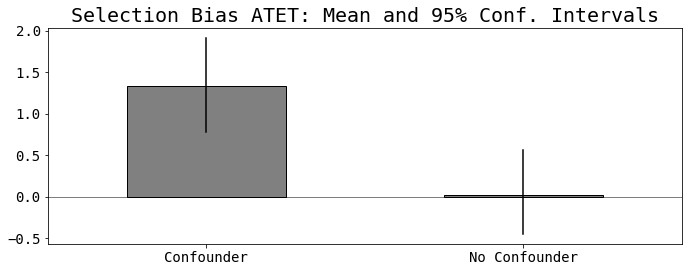

In [1700]:
fig, ax = plt.subplots()
mean_mc = mc_conf.loc['mean']
yerr = mc_conf.loc[['q_2.5', 'q_97.5']]
mean_mc.plot(kind='bar', ax=ax, edgecolor='k', facecolor='0.5')
ax.set_xticks([0,1])
for c, col in enumerate(yerr.columns):
    ax.plot([c,c], yerr[col])
ax.set_xticklabels(['Confounder', 'No Confounder'], rotation=0)
xmin, xmax = ax.get_xlim()
ax.plot([xmin, xmax], [0,0], lw=0.5)
ttl = ax.set_title('Selection Bias ATET: Mean and 95% Conf. Intervals', fontsize=20)

## Let's look at selection bias

Note that this uses the _Potential Outcomes_ notation that can be found in [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)


$$
E(Y_i | D_i = 1) -  E(Y_i | D_i = 0) = \underbrace{E(Y_{1i}|D_i=1) - E(Y_{0i}|D_i=1)}_{ATET} + \underbrace{E(Y_{0i}|D_i=1) - E(Y_{0i}|D_i=0)}_{\text{Selection Bias}}
$$

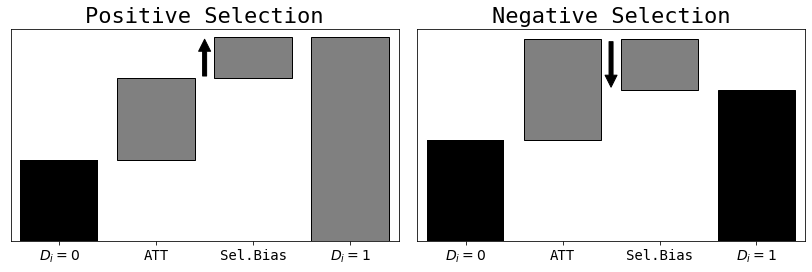

In [1701]:
# Plot to explain Positive and Negative Selection Bias
fig, ax = plt.subplots(1,2, figsize=(11.5,4))
# positive selection
ax[0].bar([0], [1])
ax[0].bar([1],bottom = 1, height=[1], color='0.5', edgecolor='k')
ax[0].bar([2],bottom = 2, height=[0.5], color='0.5', edgecolor='k')
ax[0].bar([3],bottom = 0, height=[2.5], color='0.5', edgecolor='k')
ax[0].set_xticks(range(5))
ax[0].set_xticklabels([r'$D_i=0$', 'ATT', 'Sel.Bias', r'$D_i=1$'])
ax[0].set_title('Positive Selection')
ax[0].axis([-0.5,3.5, 0,2.6])
ax[0].set_yticks([])
ax[0].set_yticklabels([])
ax[0].annotate('', xy=(1.5, 2.5), xytext=(1.5, 2),
            arrowprops=dict(facecolor='black', shrink=0.05))# negative selection
ax[1].bar([0], [1])
ax[1].bar([1],bottom = 1, height=[1], color='0.5', edgecolor='k')
ax[1].bar([2],bottom = 2, height=-0.5, color='0.5', edgecolor='k')
ax[1].bar([3],bottom = 0, height=1.5, color='0', edgecolor='k')
ax[1].set_xticks(range(5))
ax[1].set_xticklabels([r'$D_i=0$', 'ATT', 'Sel.Bias', r'$D_i=1$'])
ax[1].set_title('Negative Selection')
ax[1].axis([-0.5,3.5, 0,2.1])
ax[1].set_yticks([])
ax[1].set_yticklabels([])
arr = ax[1].annotate('', xy=(1.5, 1.5), xytext=(1.5, 2),
            arrowprops=dict(facecolor='black', shrink=0.05))# negative selection


In [1702]:
def decompose_sel_bias(nobs, seed):
    "Simulate model and compute decomposition"
    np.random.seed(seed)
    # Z ~ N(10,1)
    z = 10 + np.random.randn(nobs)
    # Binary treatment: latent variable
    # Who receive the treatment: those with HIGH latent variable values (LOW z's)
    preD = 0.5 + -3*z + np.random.randn(nobs)
    q80 = np.quantile(preD, 0.8)
    bool_D = preD>=q80
    D = 1*(bool_D)
    # Simulate outcome
    noise = np.random.randn(nobs)
    y = -0.5 + 2*D + 0.8*z + noise
    # get data that we observe and potential outcomes
    df = pd.DataFrame(columns = ['Y', 'Y0', 'Y1', 'D'])
    df['Y'] = y
    df['Y0'] = y
    df['Y1'] = y
    df['D'] = D
    df['Y0'].loc[D==1] = np.nan
    df['Y1'].loc[D==0] = np.nan
    # Decomposition
    lhs = np.mean(y[bool_D]) - np.mean(y[bool_D==False])
    y1i_di1 = y[bool_D]
    y0i_di1 = (-0.5 + 0*2*D + 0.8*z + noise)[bool_D]  # no treatment, but they should've
    y0i_di0 = y[bool_D==False]
    atet = np.mean(y1i_di1) - np.mean(y0i_di1)
    # selection bias
    sel_bias = np.mean(y0i_di1) - np.mean(y0i_di0)
    # run a regression without the confounder to show that things match
    reg = LinearRegression().fit(D.reshape((nobs,1)),y)
    coef_D = reg.coef_[0].round(decimals=3)
    print(f'Estimated effect without controlling for confounder = {coef_D}')
    print(f'LHS of equation = {lhs.round(decimals=3)}')

    return lhs, atet, sel_bias, df

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Estimated effect without controlling for confounder = 1.114
LHS of equation = 1.114


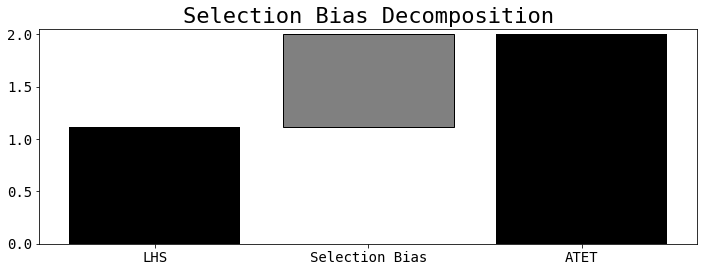

In [1703]:
nobs = 100
seed = 10417
lhs, atet, sel_bias, df = decompose_sel_bias(nobs, seed)

fig, ax = plt.subplots()
ax.bar(0, lhs)
ax.bar(1, bottom=lhs-sel_bias, height=sel_bias, color='0.5', edgecolor='k')
ax.bar(2, atet)
ax.set_ylim([0,2.05])
ax.set_xticks([0,1,2])
ax.set_xticklabels(['LHS', 'Selection Bias', 'ATET'])
ttl = ax.set_title('Selection Bias Decomposition')

## Randomization

In [1704]:
def randomize_sample(n_total, frac_treated, seed):
    "Function to find a randomized sample"
    np.random.seed(seed)
    unif_draw = np.random.rand(n_total)
    bool_treat = unif_draw >= frac_treated
        
    return bool_treat
        

In [1705]:
test = randomize_sample(n_total=100000, frac_treated=0.9, seed=11)
pct_treat = (100*test.mean()).round(decimals=1)
print(f'% of treated in sample = {pct_treat}%')

% of treated in sample = 10.0%


## Matching and Propensity Score Matching

In [1706]:
# let's simulate some data: 
# I need x1, x2 two features that drive selection: I want to see the effect of violating CIA (unconfoundedness)
# y, D
def simulate_selection_bias(nobs, seed, num_xs, true_effect):
    "Simulate selection bias using latent variable for selection mechanism"
    np.random.seed(seed)
    # X is multivariate normal with fixed COV and MU
    rho = 0.5
    preX = simulate_xmatrix_rho(nobs, num_xs, rho, seed)
    labels_x = [f'x{i}' for i in range(1,num_xs+1)]
    X = pd.DataFrame(preX, columns = labels_x)
    X['intercept'] = 1
    X = X[['intercept'] + labels_x] # reorder columns to have intercept first
    # get random coefficients in the simulation
    size_alpha = num_xs + 1
    random_alpha_z = np.random.randn(size_alpha).round(decimals=1).reshape((size_alpha,1))
    preD = np.dot(X,random_alpha_z) + np.random.randn(nobs,1) # noise ~ N(0,1)
    q80 = np.quantile(preD, 0.8)
    D = 1*(preD>=q80)
    # now model y
    K = num_xs + 2 # intercept + D + X
    random_alpha_y = np.random.randn(K).round(decimals=1).reshape((K,1))
    # Replace true effect
    random_alpha_y[-1] = true_effect
    augX = X.copy()
    augX['D'] = D
    prey = np.dot(augX, random_alpha_y) + np.random.randn(nobs,1)  # noise ~ N(0,1)
    y = pd.DataFrame(prey, index = X.index)
    # drop intercepts as these are not needed for estimation
    X.drop(columns=['intercept'], inplace=True)
    augX.drop(columns=['intercept'], inplace=True)
    # store everything in a dict
    dict_simu = {}
    dict_simu['y'] = y
    dict_simu['X'] = X
    dict_simu['D'] = pd.Series(D.flatten(), index=X.index)
    dict_simu['augX'] = augX
    dict_simu['params_y'] = random_alpha_y.flatten()
    dict_simu['params_latent'] = random_alpha_z.flatten()
    return dict_simu

In [1707]:
nobs = 1000
seed = 42616
num_xs = 2
true_effect = 2  # you can play with this parameter in your simulations
dict_sel_bias = simulate_selection_bias(nobs, seed, num_xs=2, true_effect = true_effect)
assert dict_sel_bias['params_y'][-1] == true_effect  # check that the coefficient of D on Y is -2
dict_sel_bias['augX'].cov()

,x1,x2,D
x1,0.938006,0.454704,-0.166194
x2,0.454704,1.033584,0.083192
D,-0.166194,0.083192,0.160160


In [1708]:
def match_on_prop_score(x_i, x_j, model):
    return None


def match_unit_i(x_i, X_u, size_control):
    "Match using Euclidean distance"
    # use broadcasting to calculate distances
    # note that sqrt is not needed (it's a monotonic transformation)
    if isinstance(X_u, pd.DataFrame):
        cols = X_u.columns
    else:
        _,nc = X_u.shape
        cols = [f'x{i}' for i in range(nc)]
    distance = np.power(x_i - X_u, 2)
    distance_df = pd.DataFrame(distance, columns = cols)
    distance_df['sum'] = distance_df.sum(axis=1)
    distance_sorted = distance_df.sort_values(by='sum', ascending=True)
    distance_sorted.drop_duplicates(inplace=True)
    group_i = list(distance_sorted.index[:size_control])
    
    return group_i, distance_sorted

def match_all_units_dep(X_t,X_u,y_t, y_u, size_control):
    """
    Given Xs, Ys, loop overall units
    Deprecated: works well without duplicates, but for bootstrapping I end up with dups
    """
    # find treated and start loop
    ix_treated = X_t.index
    df_delta = pd.DataFrame(index=ix_treated, columns = ['control','y1','y0', 'delta'])
    for i,ix in enumerate(ix_treated):
        x_i, y_i = X_t.loc[ix], y_t.y.loc[ix]
        gi,_ = match_unit_i(x_i, X_u, size_control)
        y0_i = y_u.y.loc[gi].mean()
        delta_i = y_i - y0_i
        df_delta.loc[ix] = [gi, y_i, y0_i, delta_i]
    df_delta.drop_duplicates(inplace=True)
    return df_delta

def match_all_units(X_t,X_u,y_t, y_u, size_control):
    """
    Given Xs, Ys, loop overall units
    Introduced some changes to handle duplicates (bootstrapping)
    """
    # find treated and start loop
    # For bootstrapping I have to take care of duplicates
    ix_treated = X_t.index
    counts_ix = ix_treated.value_counts()
    df_delta = pd.DataFrame(index=ix_treated, columns = ['control','y1','y0', 'delta'])
    y_t = y_t[~y_t.index.duplicated(keep='first')]
    for i,ix in enumerate(ix_treated):
        n_reps = counts_ix.loc[ix]
        x_i, y_i = X_t.loc[ix], y_t.y.loc[ix]
        gi,_ = match_unit_i(x_i, X_u, size_control)
        y0_i = y_u.y.loc[gi].mean()
        delta_i = y_i - y0_i
        if n_reps>1:
            df_delta.loc[ix] = np.tile(np.array([gi, y_i, y0_i, delta_i]), (n_reps,1))
        else:
            df_delta.loc[ix] = [gi, y_i, y0_i, delta_i]
    return df_delta

def compute_matching_estimator(X,y,D, size_control=1):
    "Function to compute matching estimator"
    y.rename(columns={y.columns[0]:'y'}, inplace=True)
    treated = D == 1
    untreated = treated==False
    X_t = X[treated]
    y_t = y[treated]
    X_u = X[untreated]
    y_u = y[untreated]
    df_delta = match_all_units(X_t, X_u, y_t, y_u, size_control)
    att = df_delta.delta.mean()
    return att, df_delta

In [1709]:
def top_k_columns(df, k):
    "Find best matches (columns) for each unit in the rows"
    return df.apply(lambda x: x.nsmallest(k).index.tolist(), axis=1)

In [1710]:
def match_all_units_broadcast(X_t,X_u,y_t, y_u, size_control):
    """
    Given Xs, Ys, loop overall units
    Introduced some changes to handle duplicates (bootstrapping)
    This version uses broadcasting to make it faster
    """
    # compute distance using broadcasting
    diff = D = X_t.values[:, np.newaxis] - X_u.values
    predist = np.sum(diff**2, axis=2)
    distance = pd.DataFrame(predist, index=X_t.index, columns=X_u.index)
    matches = top_k_columns(df=distance, k=size_control)
    y0 = matches.apply(lambda x: y_u.loc[x].mean())
    delta = y_t - y0
    # arrange everything in a dataframe
    df_delta = pd.DataFrame(matches, columns = ['control'])
    df_delta['y1'] = y_t
    df_delta['y0'] = y0
    df_delta['delta'] = delta
    return df_delta

def compute_matching_estimator_bcast(X,y,D, size_control=1):
    "Function to compute matching estimator: uses broadcasting"
    y.rename(columns={y.columns[0]:'y'}, inplace=True)
    treated = D == 1
    untreated = treated==False
    X_t = X[treated]
    y_t = y[treated]
    X_u = X[untreated]
    y_u = y[untreated]
    df_delta = match_all_units_broadcast(X_t, X_u, y_t, y_u, size_control)
    att = df_delta.delta.mean()
    return att, df_delta

In [1711]:
# now estimate Propensity Score Matching
def estimate_prop_score(X,D, algorithm):
    """Return the probability scores trained on D = f(X)
    method: any classifier in scikit-learn that has predict_proba
    For GBC: uses default settings, but you can easily customize it
    """
    mod = algorithm.fit(X=X, y=D)
    scores = mod.predict_proba(X)[:,1]
    # split scores to use previous functions
    ix_treated = X[D==1].index
    ix_untreat = X[D==0].index
    scores_t = pd.DataFrame(scores[D==1], columns=['score'], index=ix_treated)
    scores_u = pd.DataFrame(scores[D==0], columns=['score'], index=ix_untreat)
    return scores_t, scores_u, scores

def compute_prop_match_bcast(X,y,D, algorithm=GradientBoostingClassifier(), size_control=1):
    "Function to compute matching estimator: uses broadcasting"
    y.rename(columns={y.columns[0]:'y'}, inplace=True)
    # 1. Get propensity scores
    scores_t, scores_u,_ = estimate_prop_score(X,D, algorithm)
    # 2. Assign groups
    treated = D == 1
    untreated = treated==False
    X_t = scores_t
    y_t = y[treated]
    X_u = scores_u
    y_u = y[untreated]
    # 3. Rest is the same
    df_delta = match_all_units_broadcast(X_t, X_u, y_t, y_u, size_control)
    att = df_delta.delta.mean()
    return att, df_delta

In [1712]:
def change_type(df,mytype):
    "helper function for tests"
    dfnew = df.copy()
    for c, col in enumerate(df.columns):
        try:
            dfnew[col] = dfnew[col].astype(mytype)
        except ValueError:
            a = 1
            
    return dfnew

In [1713]:
# testing the functions
# match_unit_i: best is 0 (the same)
x_i = np.array([1,0])
X_u = np.array([[1,0],[0,1],[0.5,0.5]])
test_mi,_ = match_unit_i(x_i, X_u, size_control=1)
assert test_mi==[0]

# match_all_units
cols = ['x1','x2','x3']
X_t = pd.DataFrame(np.array([[0,0,0],[0,1,0],[0,0,1],[1,1,0],[1,0,1]]), columns=cols, index=range(5))
X_u = X_t.copy()  # for testing: use a copy, so the match should always be itself
X_u.set_index(np.arange(5,10), inplace=True)
y_t = pd.DataFrame(np.array([1]*X_t.shape[0]), columns=['y'], index=range(5))
y_u = pd.DataFrame(np.array([2]*X_t.shape[0]), columns=['y'], index=np.arange(5,10))
matched_gi = [[5],[6],[7],[8],[9]]
test_mau = match_all_units(X_t,X_u,y_t, y_u, size_control=1)
assert list(test_mau.control) == matched_gi

# compare match_all_units and match_all_units_broadcast
test_maub = match_all_units_broadcast(X_t,X_u,y_t, y_u, size_control=1)
test_maub = change_type(df=test_maub,mytype=int)
assert np.all(test_mau == test_maub)

# compute matching estimator: with the previous dataset: ATT = -1
X = pd.concat((X_t, X_u), axis = 0)
X.reset_index(inplace=True)
y = pd.DataFrame(np.concatenate((y_t, y_u), axis=0))
D = np.array([1]*5 + [0]*5)
att, _ = compute_matching_estimator(X,y,D)
assert -1 == att


In [1714]:
# let's run the matching estimator un the simulated dataset
y = dict_sel_bias['y']
D = dict_sel_bias['D']
X = dict_sel_bias['X']

In [1715]:
decimals=4
att_simu1, df_simu = compute_matching_estimator(X,y,D, size_control=1)
print(f'Estimated Average Treatment Effect on the Treated = {att_simu1.round(decimals=decimals)}')
print(f'True ATT = {true_effect}')

Estimated Average Treatment Effect on the Treated = 2.1462
True ATT = 2


In [1716]:
att_simu2, df_simu2 = compute_matching_estimator_bcast(X,y,D, size_control=1)
att_simu2 = np.around(att_simu2, decimals=decimals)
print(f'Estimated Average Treatment Effect on the Treated (broadcasting)= {att_simu2}')
print(f'True ATT = {true_effect}')

Estimated Average Treatment Effect on the Treated (broadcasting)= 2.1462
True ATT = 2


#### Note how broadcasting improved the efficiency of the matching estimator

In [1717]:
%%timeit
att_simu1, df_simu = compute_matching_estimator(X,y,D, size_control=1)

1.94 s ± 245 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [1718]:
%%timeit
att_simu2, df_simu2 = compute_matching_estimator_bcast(X,y,D, size_control=1)

577 ms ± 71.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [1719]:
# Estimate confidence intervals using Bootstrapping
B = 300
boot_att = pd.DataFrame(index=range(B), columns = ['att'], dtype='float')
for b in range(B):
    # sample with replacement (note: this creates some duplicates)
    ix_b = np.random.choice(y.index, size = y.shape[0], replace=True)
    y_b, X_b, D_b = y.loc[ix_b], X.loc[ix_b], D[ix_b]
    att_b, _ = compute_matching_estimator_bcast(X_b,y_b,D_b, size_control=1)
    boot_att.att.loc[b] = att_b

mean_boot = boot_att.att.mean()
qtle_boot = boot_att.quantile([0.025, 0.975])

Text(0.1, 2, '-- True Effect')

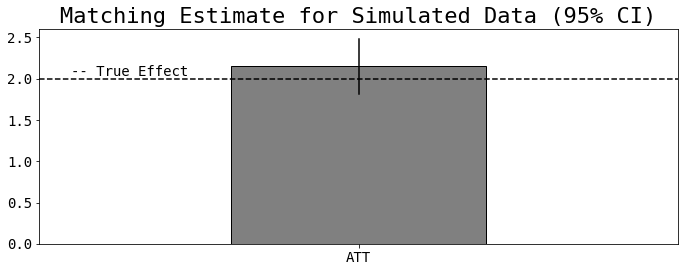

In [1720]:
fig, ax = plt.subplots()
ax.bar([1], mean_boot, color='0.5', edgecolor='k')
ax.plot([1,1], qtle_boot)
ax.set_xlim([0,2])
ax.set_title('Matching Estimate for Simulated Data (95% CI)')
ax.set_xticks([1])
ax.set_xticklabels(['ATT'])
ax.plot([0,2],[true_effect, true_effect], ls='--')
ax.text(0.1,2,'-- True Effect', verticalalignment='bottom', horizontalalignment='left')

In [1721]:
# let's estimate the impact of using larger control groups
ctr_grid = [1,2,3]
B = 100
boot_att1 = pd.DataFrame(index=range(B), columns = ctr_grid, dtype='float')
for c in ctr_grid:
    for b in range(B):
        # sample with replacement (note: this creates some duplicates)
        ix_b = np.random.choice(y.index, size = y.shape[0], replace=True)
        y_b, X_b, D_b = y.loc[ix_b], X.loc[ix_b], D[ix_b]
        att_b, _ = compute_matching_estimator_bcast(X_b,y_b,D_b, size_control=c)
        boot_att1[c].loc[b] = att_b

In [1722]:
mean_boot1 = boot_att1.mean()
qtle_boot1 = boot_att1.quantile([0.025, 0.975])   

Text(0.5, 0, 'Number of units in control group ($m$)')

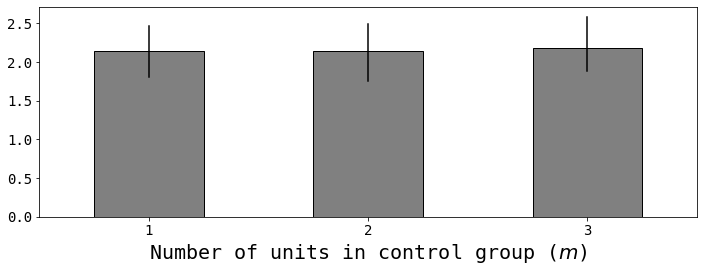

In [1723]:
fig, ax = plt.subplots()
mean_boot1.plot(kind='bar', ax=ax, color='0.5', edgecolor='k')
cols_qtle = qtle_boot1.columns.values
xtk = ax.set_xticks([0,1,2])
for c,col in enumerate(cols_qtle):
    ax.plot([c,c], qtle_boot1[col])
ax.set_xlim([-0.5,2.5])
ax.set_xticklabels(cols_qtle, rotation=0)
ax.set_xlabel(r'Number of units in control group ($m$)')
#ax.set_title('ATT for Matching Simulation')

### Now propensity score matching

In [1724]:
ps_att, df_ps = compute_prop_match_bcast(X,y,D, size_control=3)
print(f'ATT from Prop. Score = {np.around(ps_att,decimals=2)}')

ATT from Prop. Score = 1.47


In [1725]:
# let's estimate the impact of using larger control groups
# I want to get Gradient Boosting and Logistic Regression estimates
ctr_grid = range(1,5)
B = 100
boot_att_ps_gb = pd.DataFrame(index=range(B), columns = ctr_grid, dtype='float')
boot_att_ps_log = pd.DataFrame(index=range(B), columns = ctr_grid, dtype='float')
for c in ctr_grid:
    for b in range(B):
        # sample with replacement (note: this creates some duplicates)
        ix_b = np.random.choice(y.index, size = y.shape[0], replace=True)
        y_b, X_b, D_b = y.loc[ix_b], X.loc[ix_b], D[ix_b]
        att_gb, _ = compute_prop_match_bcast(X_b,y_b,D_b, size_control=c, algorithm=GradientBoostingClassifier())
        att_lo, _ = compute_prop_match_bcast(X_b,y_b,D_b, size_control=c, algorithm=LogisticRegression())
        boot_att_ps_gb[c].loc[b] = att_gb
        boot_att_ps_log[c].loc[b] = att_lo

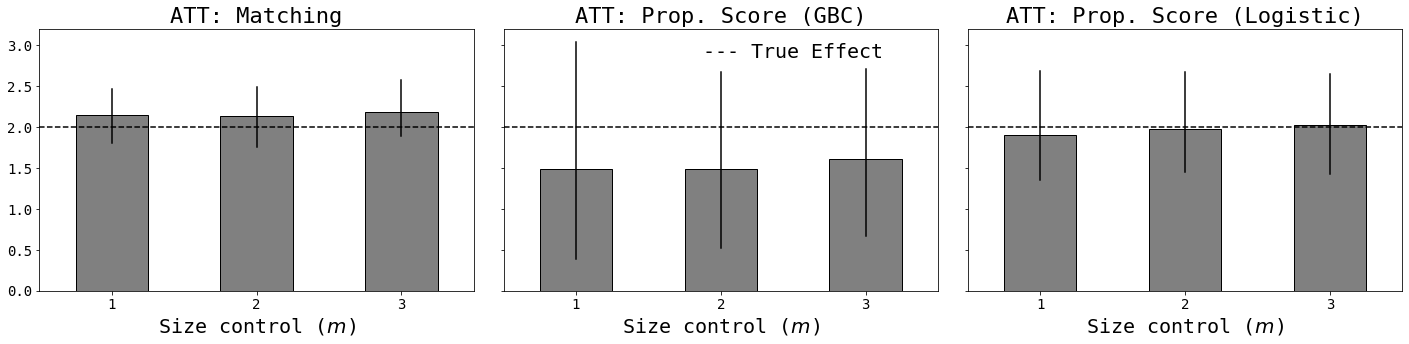

In [1726]:
dict_ps = {0:boot_att1, 1:boot_att_ps_gb, 2:boot_att_ps_log}
fig, ax = plt.subplots(1,3, figsize=(20,5), sharey=True)
dict_ttl = {0:'ATT: Matching', 1: 'ATT: Prop. Score (GBC)', 2: 'ATT: Prop. Score (Logistic)'}
for i in range(3):
    df_i = dict_ps[i]
    mean_i = df_i.mean()
    qtle_i = df_i.quantile([0.025, 0.975])
    cols_qtle = qtle_i.columns.values
    if i>0:
        mean_i = mean_i[cols_qtle[:-1]]
        qtle_i = qtle_i[cols_qtle[:-1]]
        cols_qtle = qtle_i.columns.values
    # plot
    mean_i.plot(kind='bar', ax=ax[i], color='0.5', edgecolor='k')
    #xtk = ax[i].set_xticks(cols_qtle)
    for c,col in enumerate(cols_qtle):
        ax[i].plot([c,c], qtle_i[col])
    ax[i].set_xlim([-0.5,2.5])
    ax[i].set_xticklabels(cols_qtle, rotation=0)
    ax[i].set_xlabel(r'Size control ($m$)')    
    ax[i].set_title(dict_ttl[i], fontsize=22)
    xmin, xmax = ax[i].get_xlim()
    ax[i].plot([xmin, xmax], [true_effect, true_effect], ls='--')
    if i==1:
        ax[i].text(1.5,2.8, '--- True Effect', fontsize=20, horizontalalignment='center', 
                  verticalalignment='bottom')

### Horvitz and Thompson (1952) type estimators

As shown in Angrist and Pischke, (https://press.princeton.edu/books/paperback/9780691120355/mostly-harmless-econometrics) _Mostly Harmless Econometrics: An Empiricist's Companion_, under unconfoundedness, there's an estimand that you can use and avoids the computational complexity of the matching estimators.

**ATE**:
$$
    E(Y_{1i} - Y_{0i}) = E\left(\frac{(D_i - p(X_i))Y_i}{p(X_i)(1-p(X_i))}\right)
$$

**ATT**:
$$
    E(Y_{1i} - Y_{0i}|D_i=1) = E\left(\frac{(D_i - p(X_i))Y_i}{P(D_i=1)(1-p(X_i))}\right)
$$


In [1727]:
def compute_ht_estimators(X,y,D, algorithm=LogisticRegression()):
    "Estimate the ATE and ATT via Horvitz-Thompson type estimators"
    _,_, scores = estimate_prop_score(X,D, algorithm)
    scores = pd.Series(scores, name = 'score', index = X.index)
    # ATE
    numerator = (D - scores)*y.y
    denominator = scores*(1-scores)
    pre_ate = numerator/denominator
    ate = pre_ate.mean()
    # ATT
    # the only difference is that I use the unconditional probability
    unc_prob = D.mean()  # sample probability
    denom_att = unc_prob*(1-scores)
    pre_att = numerator/denom_att
    att = pre_att.mean()
    
    return ate, att

In [1728]:
ate_ht, att_ht = compute_ht_estimators(X,y,D)
print(f'Horvitz-Thompson: ATE = {ate_ht}, ATT = {att_ht}')

Horvitz-Thompson: ATE = 1.3868257787650988, ATT = 2.2857809561052083


## Finally, simulate a model, but exclude one variable

* This should serve as a cautionary tale that you should always think hard about **selection on observables**

In [1729]:
def simulate_cia_violation(nobs, nvars, nvars_exc, seed, true_effect):
    "Simulate a violation of unconfoundedness or Conditional Independence Assumption"
    #1. Simulate a model
    dict_simu = simulate_selection_bias(nobs, seed, num_xs=nvars, true_effect=true_effect)
    y = dict_simu['y']
    D = dict_simu['D']
    X = dict_simu['X']
    coly = y.columns[0]
    y.rename(columns={coly:'y'}, inplace=True)
    # 2. Exclude some variables
    cols = X.columns
    n_inc_vars = nvars - nvars_exc
    cols_inc = cols[:n_inc_vars]
    Xnew = X[cols_inc]
    # 3. Do matching violating Selection On Observables (you observe only the included features)
    att_ma, _ = compute_matching_estimator_bcast(Xnew,y,D, size_control=1)
    ate_ht, att_ht = compute_ht_estimators(Xnew,y,D)
    
    return att_ma, ate_ht, att_ht

In [1730]:
# let's generate a large model and keep excluding
true_effect = -3
nvars = 5
grid_exc = range(0,nvars)
nobs = 1000
seed = 12898
df_cia = pd.DataFrame(index = grid_exc, columns = ['att','ate_ht', 'att_ht'], dtype=float)
for g,gr in enumerate(grid_exc):
    att_ma_g, ate_ht_g, att_ht_g = simulate_cia_violation(nobs, nvars, nvars_exc=gr, seed=seed, 
                                                          true_effect=true_effect)
    df_cia.loc[gr] = [att_ma_g, ate_ht_g, att_ht_g]

Text(0.5, 0, 'Number of Unobserved Variables (out of 5)')

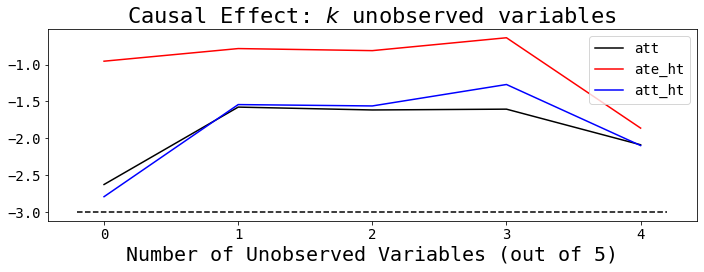

In [1731]:
fig, ax = plt.subplots()
df_cia.plot(ax=ax, color = ['k', 'r','b'])
xmin, xmax = ax.get_xlim()
ax.plot([xmin, xmax], [true_effect, true_effect], ls='--')
xt = ax.set_xticks(df_cia.index)
ax.set_title(r'Causal Effect: $k$ unobserved variables ')
ax.set_xlabel(f'Number of Unobserved Variables (out of {nvars})')

## figure for discussion of uplift modeling

Text(0.5, 0, 'Probability Scores')

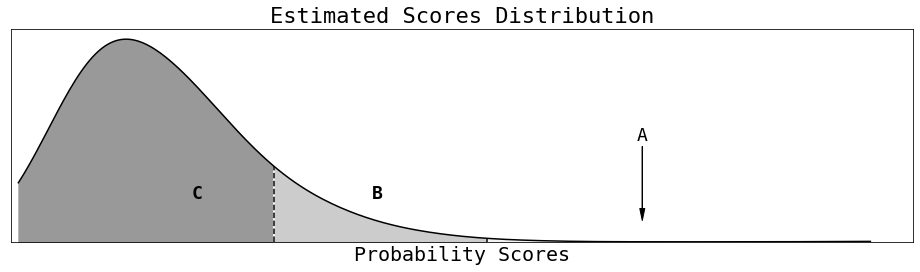

In [1732]:
nobs = 1000
seed = 30218
gamma_draws = np.random.gamma(shape=3.0, scale=1, size=nobs)
density = gaussian_kde(gamma_draws)
gridx = np.linspace(gamma_draws.min(),gamma_draws.max(),300).flatten()
density.covariance_factor = lambda : 0.5
density._compute_covariance()
y_kde = density(gridx)
fig, ax = plt.subplots(figsize=(13,4))
ax.plot(gridx,y_kde)
ax.set_title('Estimated Scores Distribution')
ax.set_yticklabels([])
ax.set_yticks([])
G = 50
# plot those that will purchase organically: group A
thresh = np.quantile(gridx, 0.55)
ax.fill_between(gridx, y_kde, where = gridx >= thresh, color='0.95')
ax.plot([thresh, thresh],[0,density(thresh)], ls='--')
ax.annotate('A', xy=(0.7, 0.1), xycoords=ax.transAxes,
            xytext=(0.7, 0.5), textcoords=ax.transAxes, va='center', ha='center',
            arrowprops=dict(facecolor='black', shrink=0., width = 0.1, headwidth = 5),
            fontsize=18)
# next group
thresh1 = np.quantile(gridx, 0.3)
bool_x = np.logical_and(gridx >=thresh1, gridx <= thresh)
ax.fill_between(gridx, y_kde, where = bool_x, color='0.8')
ax.plot([thresh1, thresh1],[0,density(thresh1)], ls='--')
ax.text(0.4,0.2, 'B', transform = ax.transAxes, fontsize=18, weight='bold')
# final group
ax.text(0.2,0.2, 'C', transform = ax.transAxes, fontsize=18, weight='bold')
ax.fill_between(gridx, y_kde, where = gridx < thresh1, color='0.6')
# change xticks
ax.set_xticks([])
xtl = ax.set_xticklabels([])
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()
ax.set_ylim([0,ymax])
ax.set_xlim([0,xmax])
ax.set_xlabel('Probability Scores')


## Double Machine Learning

The model is like this:

$$
\begin{eqnarray}
y &=& \theta_0 D + g_0(X) + u \\
D &=& m_0(X) + v
\end{eqnarray}
$$

In [1733]:
def estimate_dml_subsample(X,y,D,ix_sample, D_is_binary):
    # fix samples first
    Xs = X.loc[ix_sample]
    ys = y.loc[ix_sample].values.flatten()
    Ds = D.loc[ix_sample]
    # other
    ix_other = list(set(X.index) - set(ix_sample))
    Xo = X.loc[ix_other]
    yo = y.loc[ix_other].values.flatten()
    Do = D.loc[ix_other]
    # estimate models and residuals using first sample
    mod_y = GradientBoostingRegressor().fit(Xs,ys)
    # 2. Use ML to estimate \hat{E(D|x)}
    if D_is_binary:
        mod_d = GradientBoostingClassifier().fit(Xs,Ds)
    else:
        mod_d = GradientBoostingRegressor().fit(Xs,Ds)
    # 3. Get residuals using second sample
    u_hat = yo - mod_y.predict(Xo)
    if D_is_binary:
        v_hat = Do - mod_d.predict_proba(Xo)[:,1]
    else:
        v_hat = Do - mod_d.predict(Xo)
    # Evaluate on remaining sample
    nobs_o = len(yo)
    num = (1/nobs_o)*np.dot(v_hat,u_hat)
    den = (1/nobs_o)*np.dot(v_hat,Do)
    ratio = num/den
    # what would happen if I used the actual residuals and a linear regression?
    reg = LinearRegression(fit_intercept = False).fit(X=v_hat.values.reshape((nobs_o,1)), y=u_hat)
    theta_resids = reg.coef_[0]
    
    return ratio, theta_resids

In [1734]:
def estimate_dml_simple(X,y,D, D_is_binary = True):
    "Estimate Double Machine Learning"
    # Split the samples
    sple1 = np.random.choice(X.index, int(len(X)/2))
    sple2 = list(set(X.index) - set(ix_sample))
    # get estimators
    est1, theta1 = estimate_dml_subsample(X,y,D,ix_sample=sple1, D_is_binary = D_is_binary)
    est2, theta2 = estimate_dml_subsample(X,y,D,ix_sample=sple2, D_is_binary= D_is_binary)
    # average
    avg = 0.5*(est1 + est2)
    theta = 0.5*(theta1 + theta2)
    return avg, theta

In [1735]:
# simulate a linear model: this is a simple benchmark
nobs = 1000
seed = 81651
num_xs = 2
true_effect = -5  # you can play with this parameter in your simulations
dict_sel_bias = simulate_selection_bias(nobs, seed, num_xs=2, true_effect = true_effect)

y = dict_sel_bias['y']
D = dict_sel_bias['D']
X = dict_sel_bias['X']
dml_ate, dml_fw = estimate_dml_simple(X,y,D)

print(f'Double ML ATE = {dml_ate} \nTrue effect = {true_effect}')
print('---------- \n----------')
print(f'Double ML ATE (frisch-waugh) = {dml_fw}')
# this shows

Double ML ATE = -5.009797155254498 
True effect = -5
---------- 
----------
Double ML ATE (frisch-waugh) = -4.744566174300845


In [1736]:
# functions to simulate non-linear functions in the DGPs
def logistic_function(x):
    log_fn = 1/(1+ np.exp(-x))
    return log_fn

def my_cosh(x):
    mycos = np.cosh(x)
    return mycos

In [1737]:
# now simulate a nonlinear model
def simulate_nonlinear(nobs, seed, num_xs, true_effect):
    """
    Simulate selection bias with non-linear functions g and m
    Used in Double ML tests
    """
    np.random.seed(seed)
    # X is multivariate normal with fixed COV and MU
    rho = 0.5
    preX = simulate_xmatrix_rho(nobs, num_xs, rho, seed)
    labels_x = [f'x{i}' for i in range(1,num_xs+1)]
    X = pd.DataFrame(preX, columns = labels_x)
    X['intercept'] = 1
    X = X[['intercept'] + labels_x] # reorder columns to have intercept first
    # get random coefficients in the simulation
    size_alpha = num_xs + 1
    random_alpha_z = np.random.randn(size_alpha).round(decimals=1).reshape((size_alpha,1))
    gfunc = logistic_function(np.dot(X,random_alpha_z))  # USE LOGISTIC FUNCTION
    preD =  gfunc + np.random.randn(nobs,1) # noise ~ N(0,1)
    q80 = np.quantile(preD, 0.8)
    D = 1*(preD>=q80)
    # now model y
    K = num_xs + 1 # intercept + X  NOTE: I DROPPED THE TRUE EFFECT
    random_alpha_y = np.random.randn(K).round(decimals=1).reshape((K,1))
    mfunc = my_cosh(np.dot(X, random_alpha_y))  # USE COSH function
    D_eff = true_effect*D
    prey = mfunc + D_eff + np.random.randn(nobs,1)  # noise ~ N(0,1)
    y = pd.DataFrame(prey, index = X.index)
    # drop intercepts as these are not needed for estimation
    X.drop(columns=['intercept'], inplace=True)
    # store everything in a dict
    dict_simu = {}
    dict_simu['y'] = y
    dict_simu['X'] = X
    dict_simu['D'] = pd.Series(D.flatten(), index=X.index)
    dict_simu['params_y'] = random_alpha_y.flatten()
    dict_simu['params_latent'] = random_alpha_z.flatten()
    return dict_simu

In [1738]:
dict_nonlinear = simulate_nonlinear(nobs, seed, num_xs, true_effect)
y1 = dict_nonlinear['y']
D1 = dict_nonlinear['D']
X1 = dict_nonlinear['X']
dml_ate_nl = estimate_dml_simple(X1,y1,D1)

print(f'Double ML ATE = {dml_ate_nl} \nTrue effect = {true_effect}')

Double ML ATE = (-5.45208974361335, -4.846395518042739) 
True effect = -5
